# Experiment

## Perequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog vs taille du réseau
- temps de deploiement vs nombre de fonctions vs taille du réseau
- la mémoire et le cpu au niveau du noeud fog

graohes des localités : courbe qui montre combien de fonctions se répartissent sur l'edge et sur le cloud
faire varier le nombre de noeuds

Changer le nombre de fonctions que l'on déploi = saturation (x nbre de fonction)
Regarder l'évolution des temps de réponses / des violations de temps de deadline

Regarder si on satisfait les deadlines et si c'est scalable

Comparer en terme de prix = pas relevant
Définir une fonction d'utilité au niveau des enchères, par rapport au temps d'exécution




In [46]:
METRICS_PATH <- "metrics-arks"
METRICS_ARKS <- c(
    # "measures/auction-rand-01",
    # "measures/auction-rand-02",
    # "measures/auction-rand-03",
    # "measures/ward-rand-01",
    # "measures/ward-rand-02",
    # "measures/ward-rand-03",
    # "measures/auction-1",
    # "measures/auction-2",
    # "measures/auction-3",
    # "measures/auction-4",
    # "measures/auction-5",
    # "measures/auction-6",
    # "measures/ward-1",
    # "measures/ward-2",
    # "measures/ward-3",
    # "measures/first-1",
    # "measures/first-2",
    # "measures/first-3",
    # "measures/first-4",
    # "measures/first-5",
    # "measures/first-6",
    # "measures/edge-ward-25-1",
    # "measures/edge-ward-25-2",
    # "measures/edge-ward-25-3",
    # "measures/edge-ward-75-1",
    # "measures/edge-ward-75-2",
    # "measures/auction-25-1",
    # "measures/auction-25-2",
    # "measures/auction-25-3",
    # "measures/edge-first-25-1",
    # "measures/edge-first-25-2",
    # "measures/edge-first-25-3",
    # "measures/auction-long",
    # "measures/auction-long-2",
    # "measures/edge-first-long",
    # "measures/edge-ward-long"
    #"metrics_auction_2023-03-13-10-16.tar.xz"
    "metrics_auction_2023-03-13-14-24.tar.xz"
    ) # looks at "./*"

METRICS_GROUP <- c(
    # "auction-outlier",
    # "auction",
    # "auction",
    # "ward",
    # "ward",
    # "ward",
    # "auction",
    # "auction",
    # "auction",
    # "auction",
    # "auction",
    # "auction",
    # "ward",
    # "ward",
    # "ward",
    # "edge-first",
    # "edge-first",
    # "edge-first",
    # "edge-first",
    # "edge-first",
    # "edge-first",
    # "edge-ward-25",
    # "edge-ward-25",
    # "edge-ward-25",
    # "edge-ward-75",
    # "edge-ward-75",
    # "edge-ward-75",
    # "auction-25",
    # "auction-25",
    # "auction-25",
    # "edge-first-25",
    # "edge-first-25",
    # "edge-first-25",
    "auction"
    # "auction",
    # "edge-first",
    # "edge-ward"
)

In [47]:
# packages_to_have <- c('cowplot', 'reticulate', 'tidyverse', 'igraph', 'r2r', 'formattable', 'stringr', 'viridis', 'geomtextpath')

# dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE)  # create personal library
# .libPaths(Sys.getenv("R_LIBS_USER"))  # add to the path

# packages = installed.packages()
# packages = packages[, "Package"]

# if (FALSE %in% (packages_to_have %in% packages)){
#     install.packages(packages_to_have)
# }

# To call python from R
library(archive)
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)
library(stringr)
library(viridis)
library(geomtextpath)
library(cowplot)
library(data.table)


theme_set(theme(
        legend.position='bottom',
        legend.direction='vertical',
        panel.background = element_rect(fill = "white"),
        panel.grid = element_blank(),
    ))




Then, the dependencies

Load the the Python `integration.py` script to use its variable in R

In [48]:
#use_virtualenv('.venv/', required = TRUE)
# Always throws an error because it is a CLI tool; it is not made to be loaded in R
try(source_python("definitions.py"))

The graph of the network

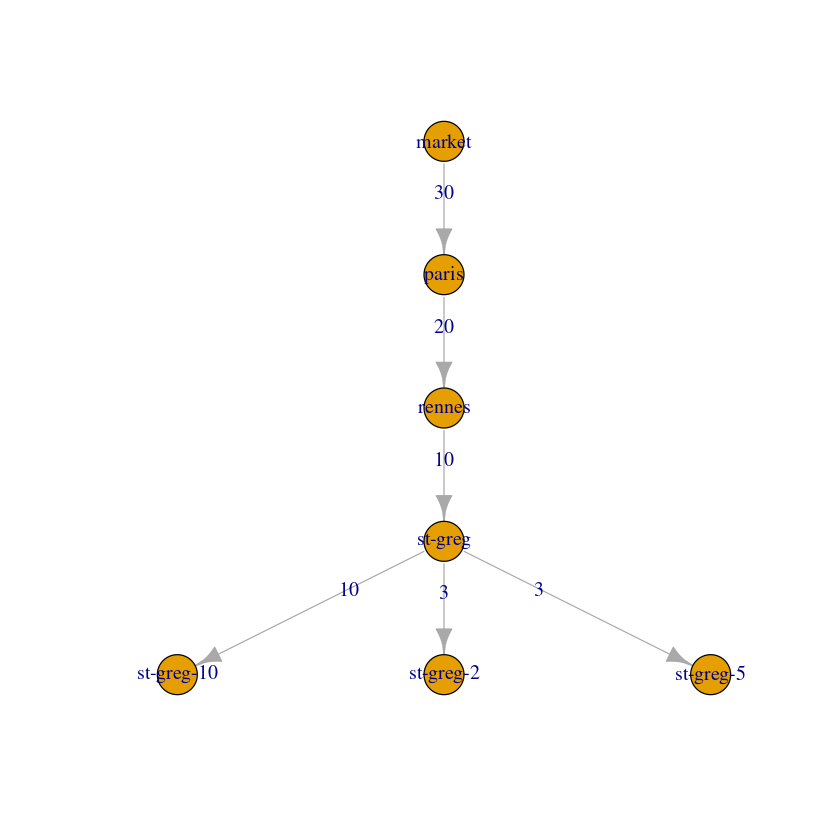

In [49]:
raw <- py$ADJACENCY

adjancy_transform <- function(x) {
  ret <- matrix(0, nrow = length(x), ncol = length(x))
  rownames(ret) <- c(sort(names(x)))
  colnames(ret) <- c(sort(names(x)))
  for (ii in seq_along(x)) {
    for (jj in seq_along(x[[ii]])) {
      ret[names(x)[[ii]], x[[ii]][[jj]][[1]]] <- strtoi(x[[ii]][[jj]][[2]])
    }
  }
  return(ret)
}

graph_matrix <- adjancy_transform(raw)
net <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
plot(net, layout = layout_as_tree, edge.label = E(net)$weight)

# ceb <- cluster_edge_betweenness(g)
#
# dendPlot(ceb, mode="hclust")
# plot(ceb, g)

Load the names of the node and their correspondance in their IP on the virtual network

In [50]:
load_csv <- function(filename) {
    all_data <- purrr::map_df(METRICS_ARKS, ~ mutate(read.csv2(archive_read(paste(METRICS_PATH, .x, sep="/"), file = filename), header = TRUE, sep = "\t"),
                                              folder = tools::file_path_sans_ext(tools::file_path_sans_ext(.x)),
                                              metric_group = METRICS_GROUP[which(METRICS_ARKS == .x)]))
    return(all_data)
}

In [51]:
names_raw <- load_csv("names.csv")
missing <- data.frame(instance = names_raw$name, n = 0)

# names_raw

In [52]:
adjust_timestamps <- function(x) {
  min_time <- min(x$timestamp)
  return (
    x %>%
      mutate(timestamp = timestamp - min_time)
  )
}

prepare <- function(x) {
  return(
    x %>%
      inner_join(names_raw,  c("instance", "folder", "metric_group")) %>%
      mutate(instance = name.y) %>%
      mutate(timestamp = as.POSIXct(as.numeric(as.character(timestamp)), origin = "1970-01-01")) %>%
      mutate(value = as.numeric(value)) %>%
      adjust_timestamps() %>%
      # merge(missing, all = TRUE) %>%
      # arrange(instance) %>%
      {.}
  )
}

extract_function_name_info <- function(x) {
  # The first element is the input string
  info <- stringr::str_match(x$function_name, "(.+)-([0-9]+)-([0-9]+)-([0-9]+)-([0-9]+)-([a-z]+)-([a-z]+)")
  return(
    x %>% 
      ungroup() %>%
      mutate(docker_fn_name =  info %>% .[,2]) %>%
      mutate(function_index =  info %>% .[,3]) %>%
      mutate(latency =  info %>% .[,4]) %>%
      mutate(cpu =  info %>% .[,5]) %>%
      mutate(mem =  info %>% .[,6]) %>%
      mutate(latency_type =  info %>% .[,7]) %>%
      mutate(load_type =  info %>% .[,8])
  )
}

## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

In [53]:
mem <- load_csv("fog_node_memory_available.csv") %>%
    prepare() %>%
    distinct(instance, value, .keep_all = TRUE) %>%
    select(c(instance, value, folder)) %>%
    mutate(dyn = formattable::percent(value / max(value, na.rm = TRUE))) %>%
    mutate(value = as.numeric(as.character(value)))

cpu <- load_csv("fog_node_cpu_used.csv") %>%
    prepare() %>%
    select(c(instance, value, folder)) %>%
    distinct(instance, value, folder, .keep_all = TRUE) %>%
    group_by(instance, folder) %>%
    mutate(value = as.numeric(as.character(value)))

[1] "metrics-arks"


Warning message in vattrs[[name]][index] <- value:
“number of items to replace is not a multiple of replacement length”


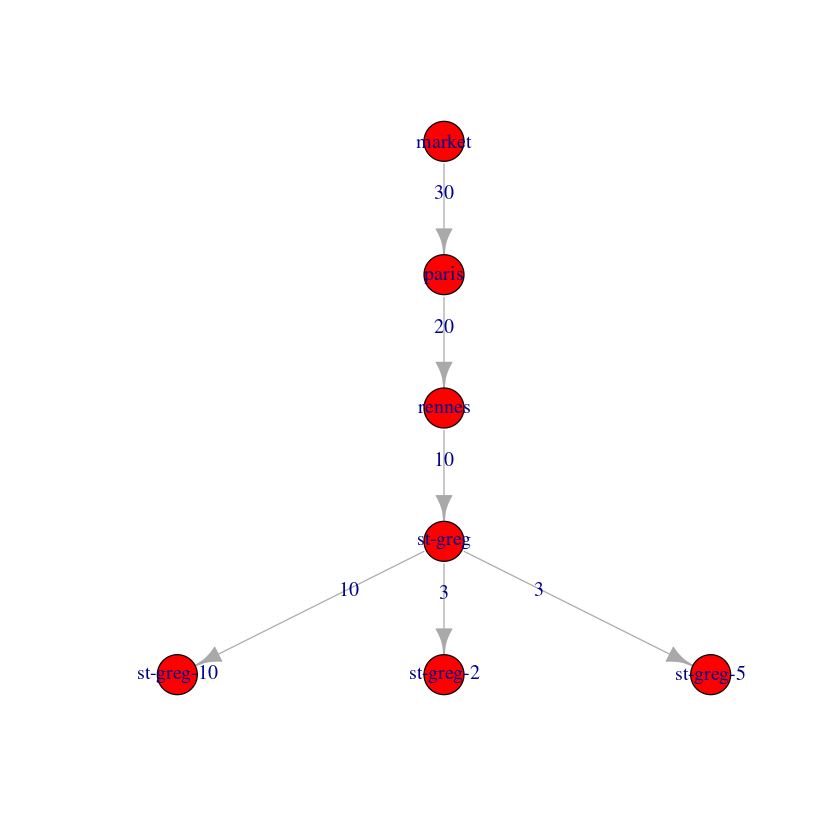

In [54]:
PercentageColourConnected <- function(x) {
    colorRampPalette(c("red", "green"))(2)[ifelse(is.na(x), 1, 2)]
}
for (folder_name in METRICS_PATH){
    print(folder_name)
    net_connected <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
    memory <- mem %>% filter(folder == folder_name) %>% select(instance, value)
    all_zero <- data.frame(instance = names_raw$name, n = 0)
    memory <- memory %>%
      merge(all_zero, all = TRUE) %>%
      group_by(instance) %>%
      summarise(across(everything(), sum)) %>%
      arrange()
    V(net_connected)$color <- PercentageColourConnected(memory$value)
    plot(net_connected, layout = layout_as_tree, edge.label = E(net_connected)$weight)
}


## Distribution of the functions in the network

`summarise()` has grouped output by 'instance'. You can override using the `.groups` argument.


[1] "metrics-arks"


Warning message in vattrs[[name]][index] <- value:
“number of items to replace is not a multiple of replacement length”


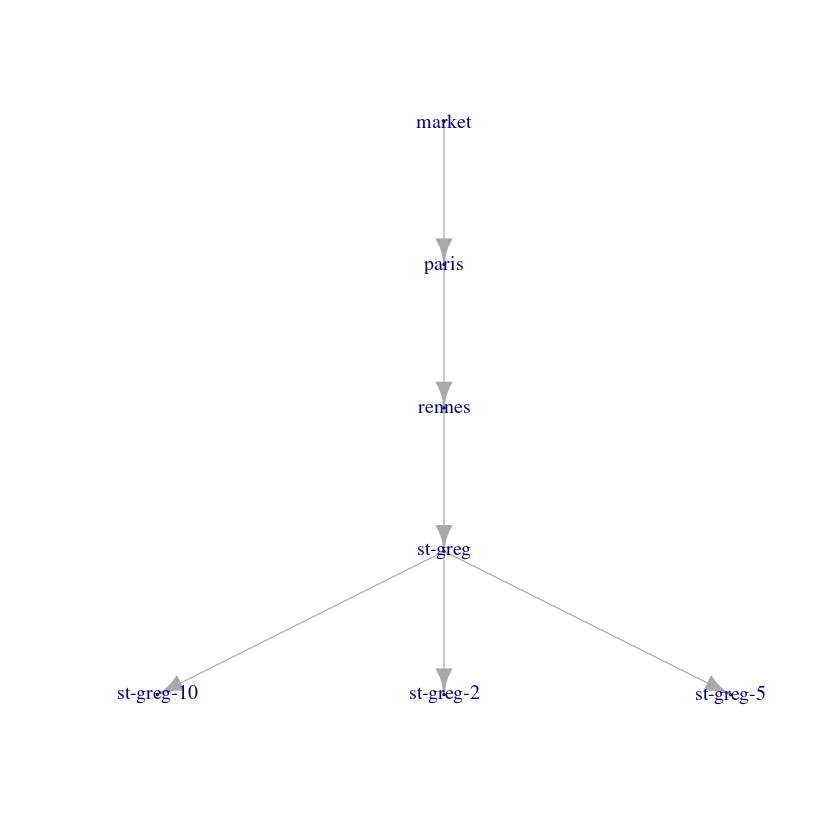

In [55]:
bids_raw <- load_csv("fog_node_bids.csv") %>% prepare()

bids_won_raw <- bids_raw %>%
  select(c(instance, function_name, value, folder))

bids_won <- bids_won_raw %>%
  group_by(function_name, folder) %>%
  slice(which.min(value)) %>%
  group_by(instance, folder) %>%
  summarise(n = n()) %>%
  # group_by(folder ) %>%
  complete(folder,  fill = list(n = 0, instance="tto")) %>%
  
{.}

# bids_won


for (folder_name in METRICS_PATH){
    print(folder_name)
    net_won <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
    won <- bids_won %>% filter(folder == folder_name) %>% select(instance, n)
    # Add missing participants and put them at 0
    bids_won_all_zero <- data.frame(instance = names_raw$name, n = 0)
    won <- won %>%
      merge(bids_won_all_zero, all = TRUE) %>%
      group_by(instance) %>% {.}
      # summarise(across(everything(), sum)) %>%
      # arrange()
    # print(won)
    V(net_won)$size <- won$n
    plot(net_won, layout = layout_as_tree)
}

Plot the free cpu

Adding missing grouping variables: `metric_group`
Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.



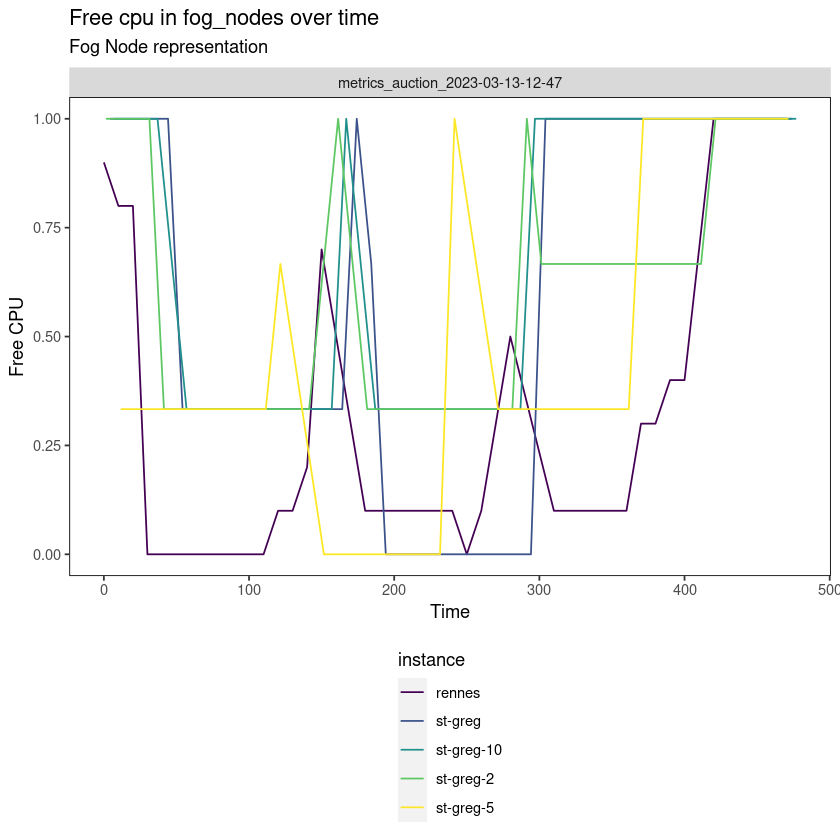

In [56]:
cpu_used <- load_csv("fog_node_cpu_used.csv") %>% prepare()
cpu_avail <- load_csv("fog_node_cpu_available.csv") %>% prepare()


cpu_free <- cpu_used %>%
  inner_join(cpu_avail, by = c("instance", "timestamp", "folder", "metric_group")) %>%
  mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance, folder, metric_group) %>%
  mutate(free_percent = formattable::percent(free / max(free))) %>%
  select(instance, timestamp, free, free_percent, folder)%>%
  drop_na()

cpu_free %>%
ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  # geom_area(position = 'stack',  color = "white") +
  geom_line() +
  labs(x = "Time", 
       y = "Free CPU", 
       title = "Free cpu in fog_nodes over time", 
       subtitle = "Fog Node representation") +
  facet_grid(cols = vars(folder), scale="free") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.



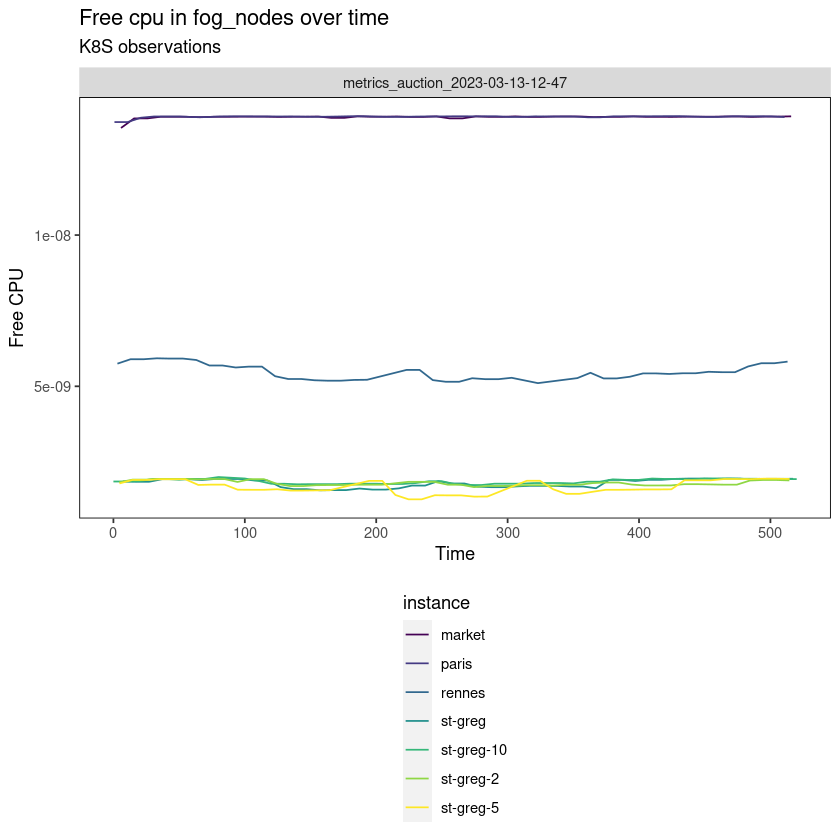

In [57]:
cpu_used <- load_csv("fog_node_cpu_usage.csv") %>% prepare()
cpu_avail <- load_csv("fog_node_cpu_allocatable.csv") %>% prepare()

cpu_free <- cpu_used %>%
  inner_join(cpu_avail, by = c("instance", "timestamp", "folder")) %>%
  mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance, folder) %>%
  mutate(free_percent = formattable::percent(free / max(free))) %>%
  select(instance, timestamp, free, free_percent, folder)%>%
  drop_na()

cpu_free %>%
ggplot(aes(x = timestamp, y = free, color = instance)) +
  # geom_area(position = 'stack',  color = "white") +
    geom_line() +
  labs(x = "Time", 
       y = "Free CPU", 
       title = "Free cpu in fog_nodes over time", 
       subtitle = "K8S observations") +
  facet_grid(cols = vars(folder), scale="free") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Plot the free memory

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.



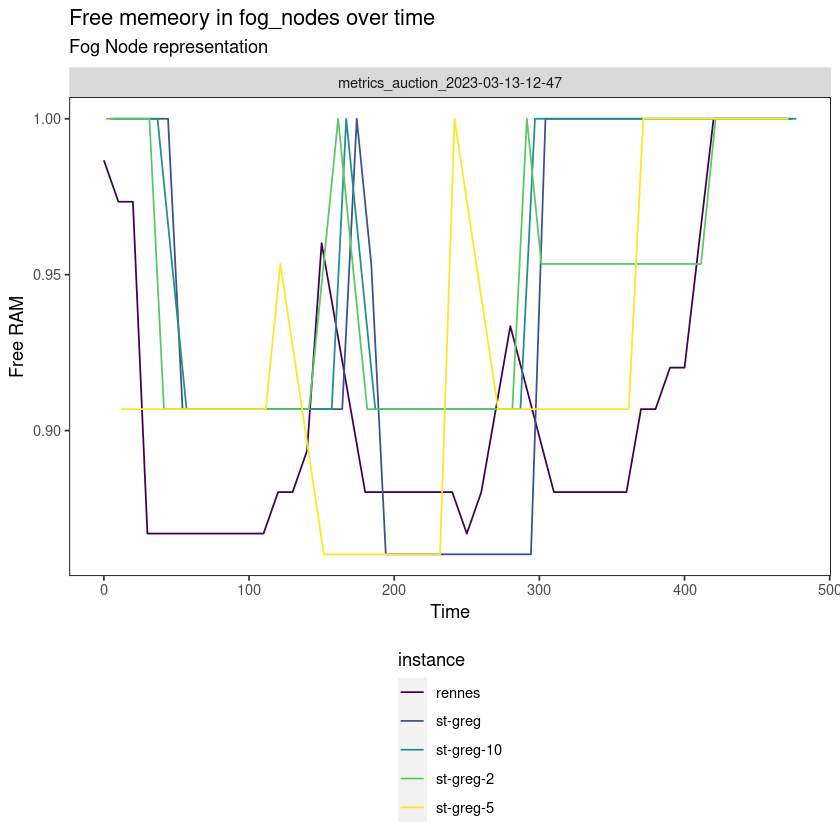

In [58]:
mem_used <- load_csv("fog_node_memory_used.csv") %>% prepare()
mem_avail <- load_csv("fog_node_memory_available.csv") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp", "folder")) %>%
mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance, folder) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent, folder) %>%
  drop_na()

mem_free %>%
  ggplot(aes(x = timestamp, y = free_percent, color = instance)) +
  # geom_area(position = 'stack', color = "white") +
    geom_line() +
  facet_grid(cols = vars(folder), scale="free") +
  labs(x = "Time", 
       y = "Free RAM", 
       title = "Free memeory in fog_nodes over time", 
       subtitle = "Fog Node representation") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.



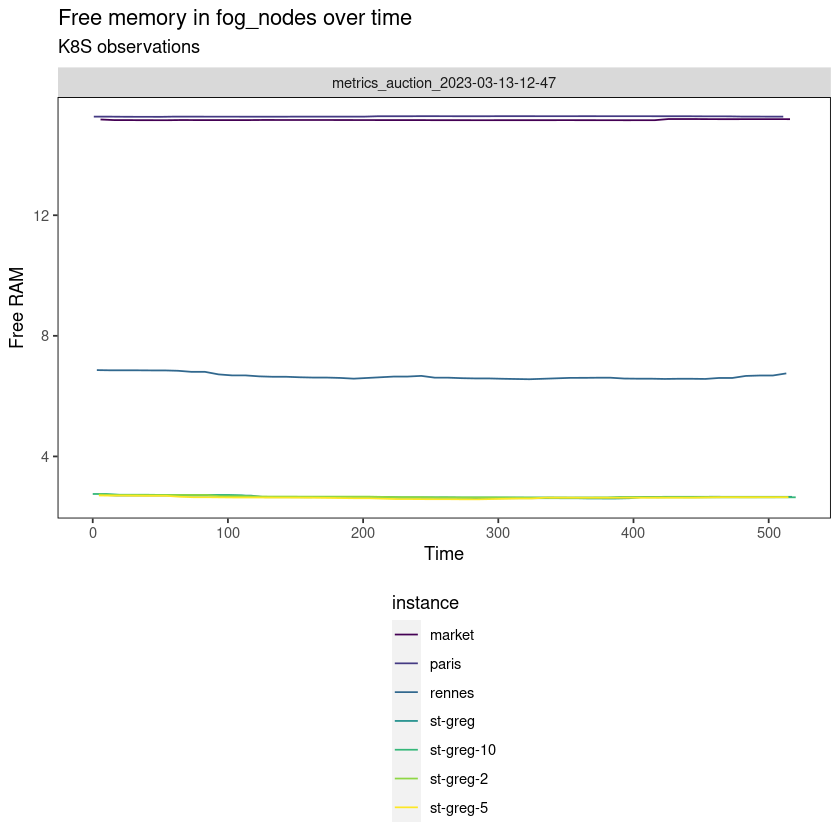

In [59]:
mem_used <- load_csv("fog_node_memory_usage.csv") %>% prepare()
mem_avail <- load_csv("fog_node_memory_allocatable.csv") %>% prepare()

mem_free <- mem_used %>%
  inner_join(mem_avail, by = c("instance", "timestamp", "folder")) %>%
mutate(free = (value.y - value.x) / 1e09) %>%
  group_by(instance, folder) %>%
  mutate(free_percent = formattable::percent(free / max(free, na.rm = TRUE))) %>%
  select(instance, timestamp, free, free_percent, folder)

mem_free %>%
  ggplot(aes(x = timestamp, y = free, color = instance)) +
  # geom_area(position = 'stack',  color = "white") +
  geom_line() +
  facet_grid(cols = vars(folder), scale="free") +
  labs(x = "Time", 
       y = "Free RAM", 
       title = "Free memory in fog_nodes over time", 
       subtitle = "K8S observations") +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) 

Latency of the nodes from their rolling average

> It is actually the double of the set latency because first the TCP connection is established and then the data flows. So those are actually: src -> dest and then src -> dest, so counting twice as long as the actual network latency.

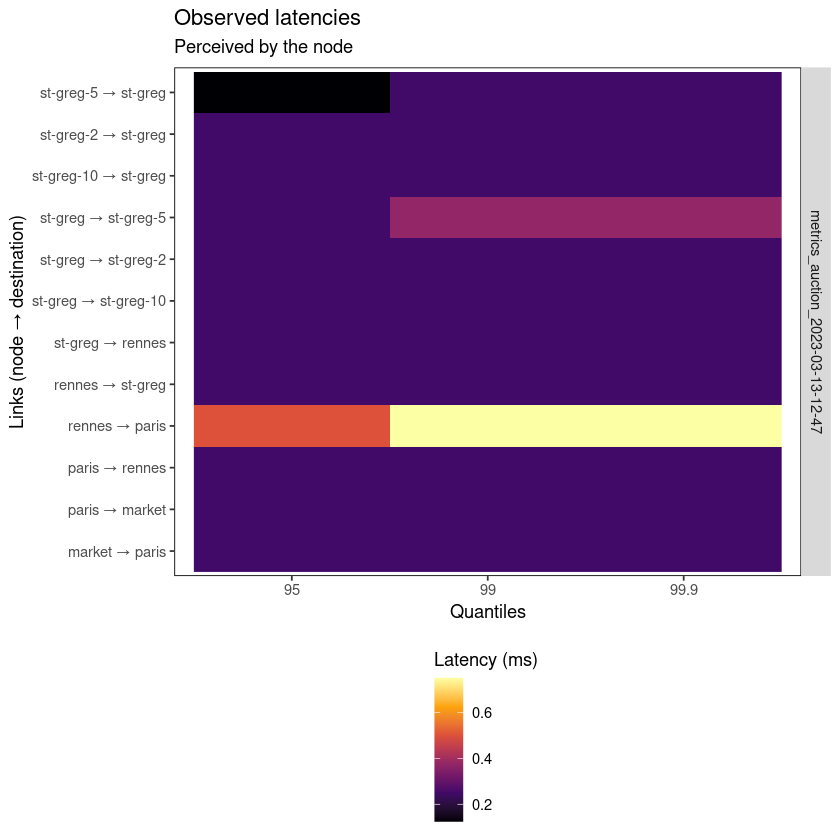

In [60]:
latency <- load_csv("fog_node_neighbors_latency_rolling_avg.csv") %>%
  prepare() %>%
  inner_join(names_raw %>% mutate(instance_to = instance) %>% mutate(destination_name = name) %>% select(-c(instance, name)),  c("instance_to", "folder", "metric_group")) %>%
  mutate(instance_to = destination_name)

p <- c(0.95, 0.99, 0.999)
p_names <- map_chr(p, ~paste0(.x*100, ""))
p_funs <- map(p, ~partial(quantile, probs = .x, na.rm = TRUE)) %>% 
  set_names(nm = p_names)

quantiles <- latency %>%
    mutate(value = value*1000) %>%
    group_by(instance, instance_to, folder) %>%
    summarize_at(vars(value), funs(!!!p_funs)) %>%
    pivot_longer(cols = -c("instance", "instance_to", "folder"), names_to = c("quantile")) %>%
    mutate(diff = value - max(graph_matrix[instance, instance_to], graph_matrix[instance_to, instance])) %>%
    {.}

quantiles %>%
    ggplot(
      aes(
        y = factor(str_replace(interaction(instance, instance_to), '\\.', ' → '), ordered = TRUE),
        x = quantile,
        fill = diff,
      )
    ) +
    geom_raster() +
    # geom_text(aes(label=round(diff)), color = "white", alpha=.7, size = 3) +
    scale_fill_viridis_c(option="inferno") + #trans = 'pseudo_log',
    # scale_fill_gradient2(low = "black", high = "white") +
    facet_grid(rows = vars(folder), scale="free") +
    labs(
      x = "Quantiles",
      y = "Links (node → destination)",
      title = "Observed latencies",
      subtitle = "Perceived by the node",
      fill = "Latency (ms)"
    )


## Bids

Adding missing grouping variables: `function_name`


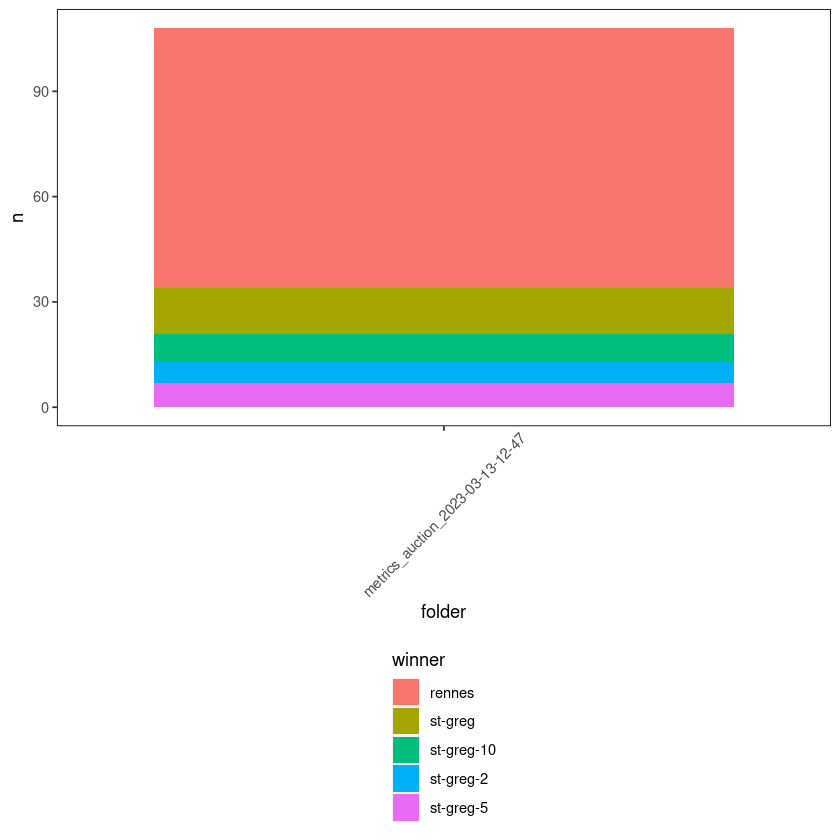

In [61]:
bids_won_function <- bids_raw %>%
  group_by(function_name, folder, metric_group) %>%
  slice(which.min(value)) %>%
  mutate(winner = instance)

# head(bids_won_function)

bids_function <- bids_raw %>%
  mutate(winner = instance) %>%
  select(instance, function_name, value, folder, metric_group) %>%
  distinct() %>%
  inner_join(bids_won_function, by = c("function_name", "folder", "metric_group")) %>%
  extract_function_name_info() %>%
  group_by(winner, latency, folder, function_name, metric_group) %>%
  select(winner, latency, folder, function_name, metric_group) %>%
  count(winner) %>%
  select(winner, latency, folder, n, metric_group) %>%
  complete() %>%
    {.}

# head(bids_function)

bids_function %>%
 ggplot(
      aes(
        y = n,
        x = folder,
        fill = winner,
      )
    ) +
    geom_col() +
    theme(
     axis.text.x = element_text(angle=45)
     )
    # geom_text(aes(label=round(diff)), color = "white", alpha=.7, size = 3) +
    # scale_fill_viridis_c(option="plasma") +
    # scale_fill_gradient2(low = "black",  high = "red") +
    # facet_grid(cols = vars(folder), rows = vars(metric_group)) 
    # labs(
    #   x = "Quantiles",
    #   y = "Links (node → destination)",
    #   title = "Observed latencies",
    #   subtitle = "Perceived by the node",
    #   fill = "Latency (ms)"
    # )

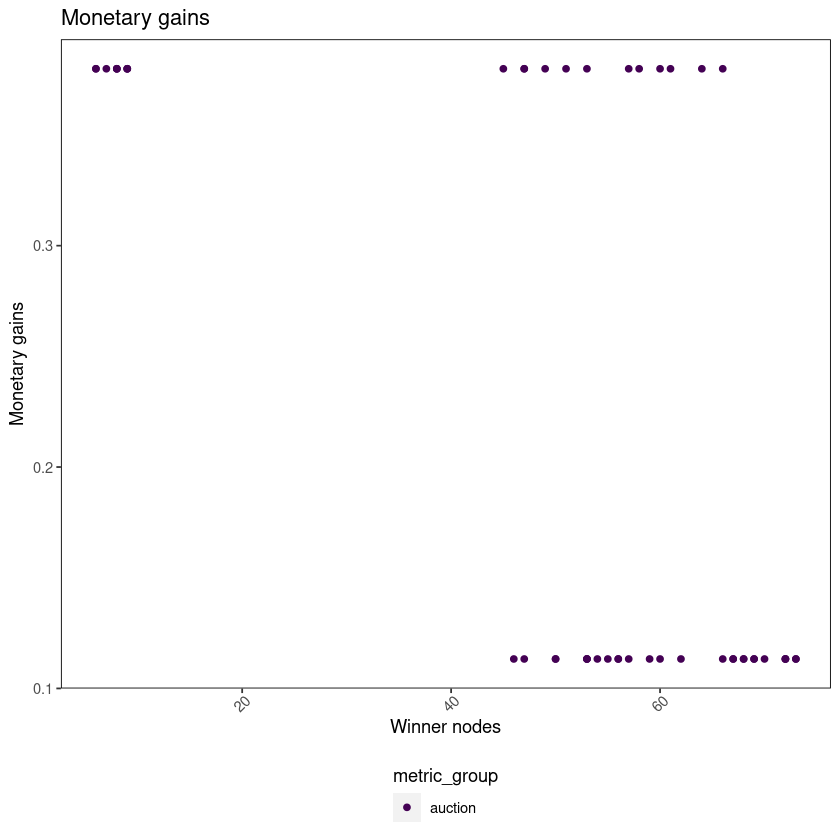

In [62]:
winner_gains <- bids_won_function %>%
    extract_function_name_info() %>%
    # select(winner, tag, value, folder, latency) %>%
    # distinct() %>%
    # group_by(folder, metric_group) %>%
    # summarise(total = sum(value)) %>%
    # group_by(winner, metric_group) %>%
    # summarise(total = mean(total))
    {.}

# head(winner_gains)

winner_gains %>%
  ggplot(aes(x = as.numeric(latency), y = as.numeric(value), color = metric_group)) +
  # geom_col(position = position_dodge(preserve = 'single')) +
  geom_point() +
  labs(x = "Winner nodes", y = "Monetary gains", title = "Monetary gains", fill = "Placement")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) +
  theme(
        axis.text.x = element_text(angle=45)
    )

Adding missing grouping variables: `metric_group`
`summarise()` has grouped output by 'winner', 'folder'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'winner'. You can override using the `.groups` argument.


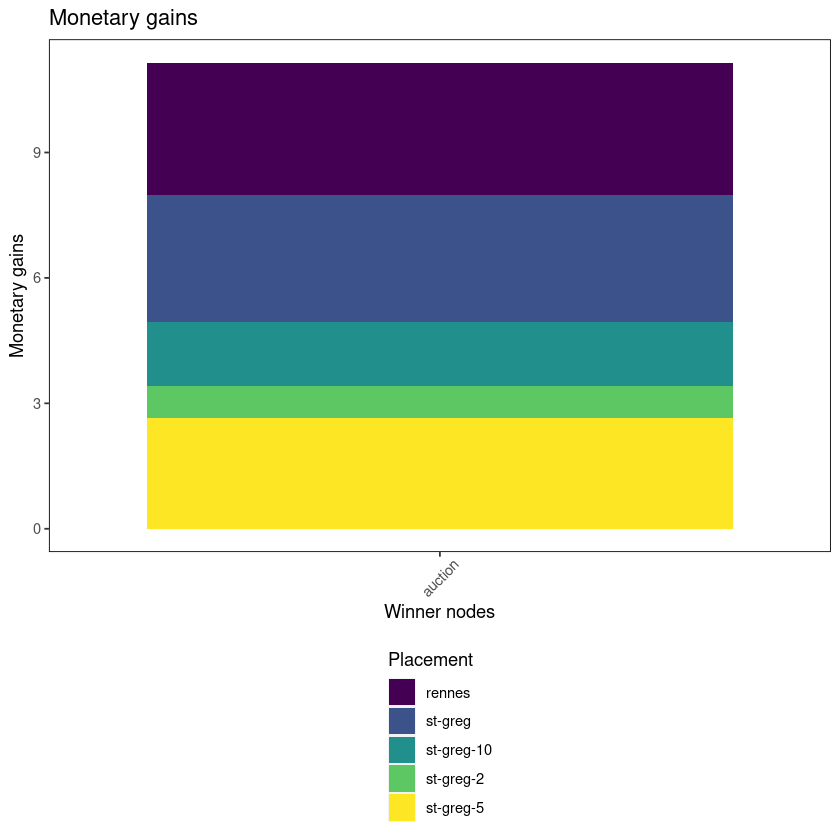

In [63]:
winner_gains <- bids_won_function %>%
  select(winner, function_name, value, folder) %>%
  distinct() %>%
  group_by(winner, folder, metric_group) %>%
  summarise(total = sum(value)) %>%
  group_by(winner, metric_group) %>%
  summarise(total = mean(total))

# head(winner_gains)

winner_gains %>%
  ggplot(aes(x = metric_group, y = total, fill = winner)) +
  # geom_col(position = position_dodge(preserve = 'single')) +
  geom_col() +
  labs(x = "Winner nodes", y = "Monetary gains", title = "Monetary gains", fill = "Placement")+
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE) +
  theme(
        axis.text.x = element_text(angle=45)
    )

## Latencies and SLAs

In [64]:
# echo_sum <-
#   load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_sum.csv") %>%
#   prepare()

# echo_count <-
#   load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_count.csv") %>%
#   prepare()

echo_bucket <-
  load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_bucket.csv") %>%
  prepare() %>%
  mutate(function_name = tag)

latencies <- echo_bucket %>%
  select(function_name, folder) %>%
  distinct() %>%
  extract_function_name_info() %>%
  select(latency, folder)


In [65]:
errors <- tryCatch(
        {
            load_csv("iot_emulation_http_request_to_processing_echo_fails.csv") %>%
                prepare() %>%
                extract_function_name_info() %>%
                distinct()
        },
        error = function(cond){
            columns = c("instance", "job", "timestamp", "tag", "period", "folder", "metric_group", "latency", "value") 
            df = data.frame(instance=character(0),job=character(0), period=numeric(0), folder=character(0), metric_group=character(0), latency=character(0),  value=numeric(0))
            return(df)
        })

Warning message in min.default(structure(numeric(0), class = c("POSIXct", "POSIXt":
“no non-missing arguments to min; returning Inf”


In [66]:
echo_bucket <- echo_bucket %>% 
    mutate(value_bucket = value) %>%
    mutate(le = ifelse(le == "+Inf", Inf, as.numeric(le))) %>%
    {.}

average <- echo_bucket %>%
    extract_function_name_info() %>%
    mutate(latency = as.numeric(latency) / 1000) %>%
    mutate(load = 1000 / as.numeric(period)) %>%
    {.}

In [67]:
average_sum <- average %>%
    select(function_name, load, folder, le, value_bucket, latency, timestamp, metric_group, latency_type, load_type) %>% 
    arrange(desc(timestamp), .by_group=TRUE) %>%
    group_by(timestamp, function_name, load, folder, le, latency, metric_group, latency_type, load_type) %>%
    filter(row_number()==n()) %>%
    # select(-timestamp) %>%
    arrange(desc(le), .by_group=TRUE) %>%
    {.}

# average_sum

under_sla <- average_sum %>%
    mutate(target_offset = round(le - latency, 3)) %>%
    filter(target_offset %in% c(-0.003, -0.002, -0.001, 0, 0.003, 0.002, 0.001)) %>%
    group_by(timestamp, function_name, load, folder, latency, target_offset, metric_group, latency_type, load_type) %>%
    select(-le) %>%
    {.}

# under_sla

sla_stats <- average_sum %>%
    filter(le == Inf) %>%
    group_by(timestamp, function_name, load, folder, latency, metric_group, latency_type, load_type) %>%
    mutate(total = value_bucket) %>%
    select(-c(value_bucket, le)) %>%
    inner_join(under_sla, by = c("timestamp", "function_name", "load", "folder", "latency", "metric_group", "latency_type", "load_type")) %>%
    mutate(above = total - value_bucket) %>%
    {.}

# sla_stats

`summarise()` has grouped output by 'folder'. You can override using the `.groups` argument.
Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.



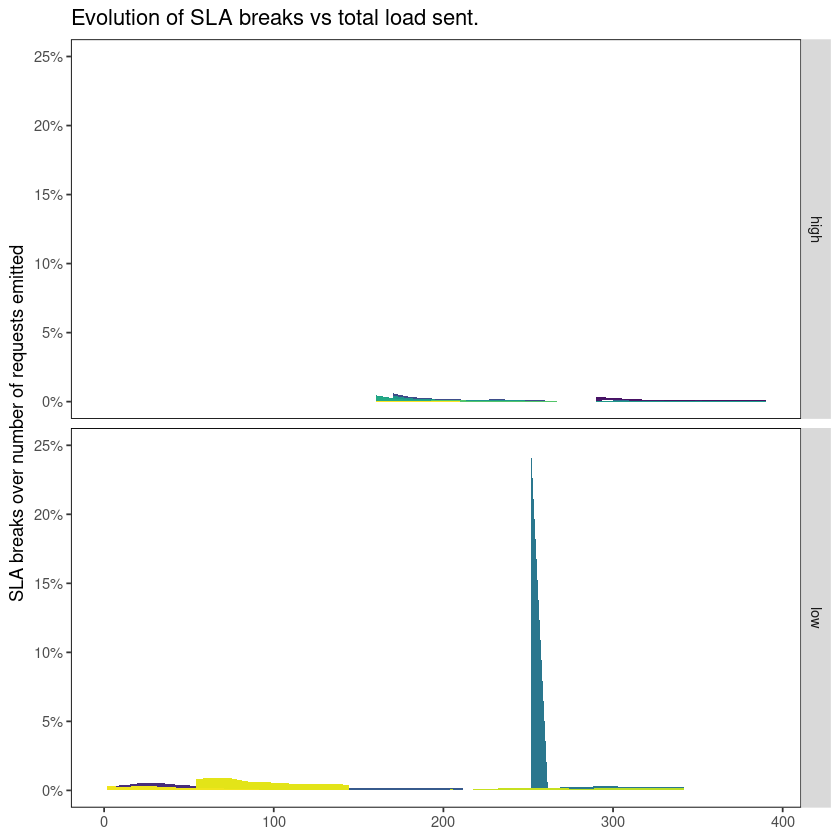

In [68]:
evol_sla_data <- sla_stats %>%
    group_by(timestamp, load, folder, target_offset, latency_type, load_type) %>%
    # summarize(above = sum(above), respected = sum(value_bucket)) %>%
    mutate(respected = sum(value_bucket)) %>%
    mutate(percent = above / (above + respected)) %>%
    # spread(key = target_offset, value = percent) %>%
    {.}

# evol_sla_data

fails <- errors %>%
    group_by(folder, period) %>%
    summarise(failed=sum(value))

fails <- fails %>%
    mutate(load = 1000 / period) %>%
    # inner_join(evol_sla_data, c("folder", "load")) %>%
    # mutate(dropped = failed / (above + respected + failed)) %>%
    {.}

# fails

# fails <- evol_sla_data %>%
#     group_by(folder, load, target_offset) %>%
#     select(folder, load, target_offset) %>%
#     left_join(fails, by = c("folder", "load")) %>%
#     {.}
# fails$dropped <- coalesce(fails$dropped, 0)


# fails

evol_sla <- evol_sla_data %>%
filter(target_offset == 0) %>%
ggplot(
  aes(
    x = timestamp,
    y = percent,
    fill = function_name,
    # fill = load_type,
    # shape = load_type,
  )
) +
# geom_col(position="dodge") +
# geom_line() +
geom_area() +
# geom_rug(sides="l") +
# geom_errorbar(aes(ymin=(evol_sla_data%>%filter(target_offset==-0.003))$percent, ymax=(evol_sla_data%>%filter(target_offset==0.003))$percent), width=0.5) +
# geom_errorbar(aes(ymin=(evol_sla_data%>%filter(target_offset==-0.002))$percent, ymax=(evol_sla_data%>%filter(target_offset==0.002))$percent), width=1.5) +
# geom_errorbar(aes(ymin=(evol_sla_data%>%filter(target_offset==-0.001))$percent, ymax=(evol_sla_data%>%filter(target_offset==0.001))$percent), width=3) +
scale_y_continuous(label=scales::percent)+
labs(
  x = "Load (req/s)",
  y = "SLA breaks over number of requests emitted",
  title = "Evolution of SLA breaks vs total load sent."
) +
facet_grid(rows = vars(latency_type)) +
scale_color_viridis(discrete = TRUE, option = "D") +
scale_fill_viridis(discrete = TRUE) +
theme(        axis.title.x = element_blank(),
        legend.position = "none")
evol_sla

# fails <- fails %>%
# ggplot(
#   aes(
#     x = load,
#     y = failed,
#     color = latency_type,
#   )
# ) +
# # geom_line() +
# geom_point() +
# # geom_rug(sides="l") +
# # scale_y_reverse(label=scales::percent) +
# scale_y_reverse()+
# # scale_x_discrete(position = "top") +
# labs(
#   x = "Load (req/s)",
#   y = "Errors",
#   # title = "Ratio of errors for send window vs load.",
#   color = "Placment model"
# ) +
#  theme(
#         axis.title.x = element_blank()) + 
# scale_color_viridis(discrete = TRUE, option = "D") +
# scale_fill_viridis(discrete = TRUE)
# fails
# cowplot::plot_grid(evol_sla, fails, ncol = 1, rel_heights = c(1, 0.75))


Adding missing grouping variables: `timestamp`, `function_name`, `metric_group`, `latency_type`, `load_type`
`summarise()` has grouped output by 'load', 'folder', 'latency'. You can override using the `.groups` argument.


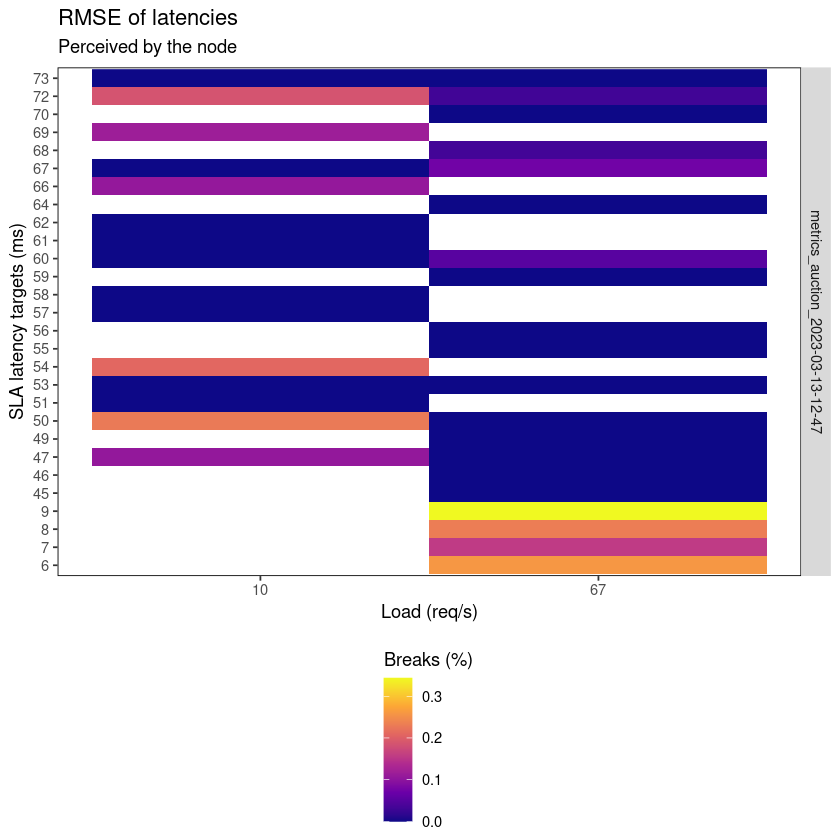

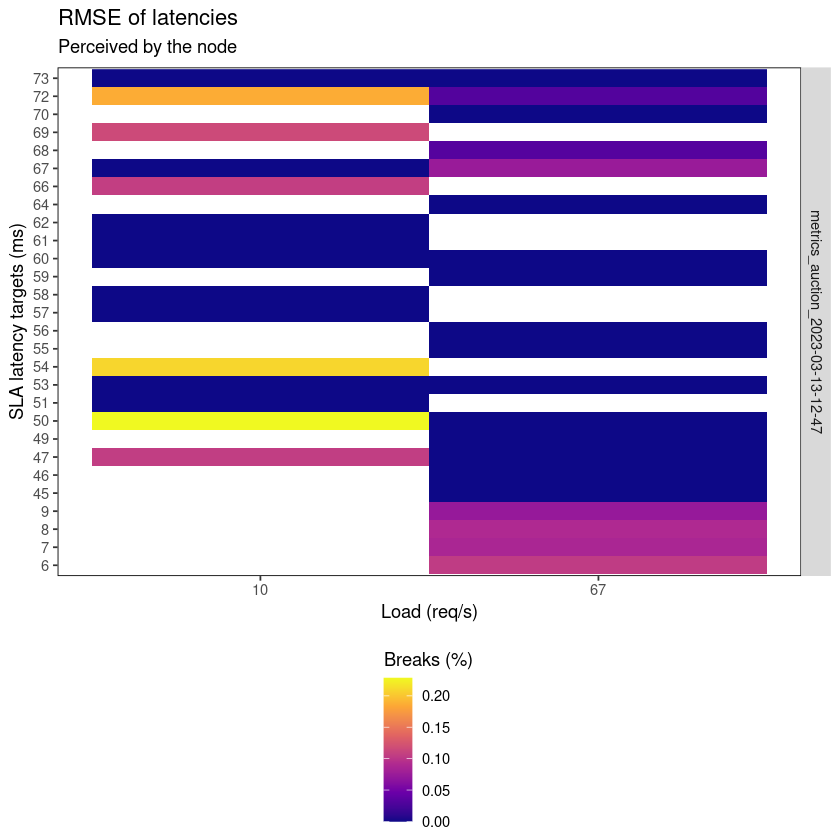

In [69]:
evol_sla_data <- sla_stats %>%
    select(load, above, value_bucket, folder, latency, target_offset) %>%
    group_by(load, folder, latency, target_offset) %>%
    summarize(above = sum(above), respected = sum(value_bucket)) %>%
    mutate(percent = above / (above + respected)) %>%
    {.}

# sla_stats
# evol_sla_data

evol_sla_data %>%
    filter(target_offset==0.000) %>%
    ggplot(
      aes(
        x = factor(round(load)),
        y = factor(latency * 1000),
        fill = percent * 100
      )
    ) +
    geom_raster() +
    # geom_text(aes(label=round(RMSE)), color = "white", alpha=.7, size = 3) +
    scale_fill_viridis_c(option="plasma", trans = 'pseudo_log') + # trans = 'pseudo_log'
    # scale_y_continuous(trans = "log10") + #, label = scales::percent) +
    facet_grid(rows = vars(folder), scales = "free") +
    labs(
      x = "Load (req/s)",
      y = "SLA latency targets (ms)",
      title = "RMSE of latencies",
      subtitle = "Perceived by the node",
      fill = "Breaks (%)"
    )


evol_sla_data %>%
    filter(target_offset==0.003) %>%
    ggplot(
      aes(
        x = factor(round(load)),
        y = factor(latency * 1000),
        fill = percent * 100
      )
    ) +
    geom_raster() +
    # geom_text(aes(label=round(RMSE)), color = "white", alpha=.7, size = 3) +
    scale_fill_viridis_c(option="plasma", trans = 'pseudo_log') + # trans = 'pseudo_log'
    # scale_y_continuous(trans = "log10") + #, label = scales::percent) +
    facet_grid(rows = vars(folder), scales = "free") +
    labs(
      x = "Load (req/s)",
      y = "SLA latency targets (ms)",
      title = "RMSE of latencies",
      subtitle = "Perceived by the node",
      fill = "Breaks (%)"
    )


`summarise()` has grouped output by 'load', 'folder', 'latency', 'metric_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'load', 'metric_group', 'latency'. You can override using the `.groups` argument.


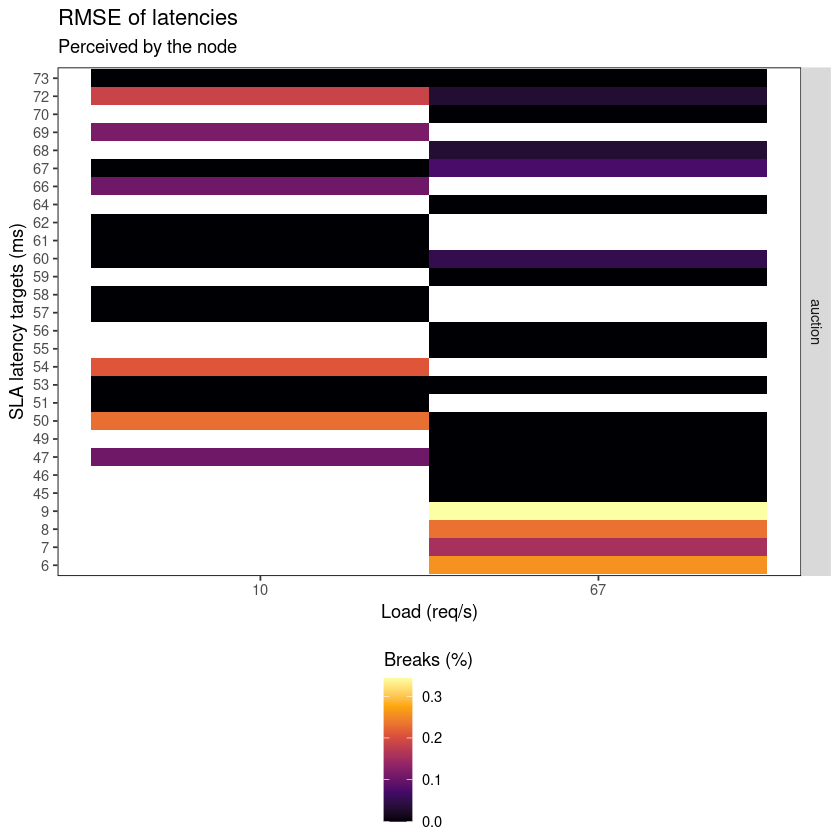

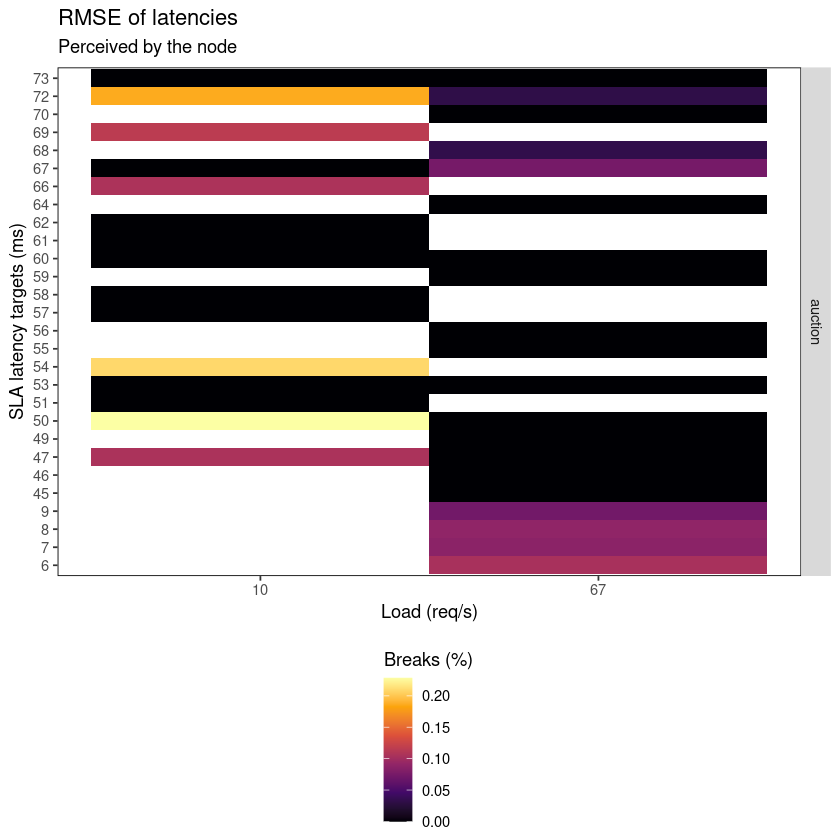

In [70]:
evol_sla_data <- sla_stats %>%
    group_by(load, folder, latency, metric_group, target_offset) %>%
    summarize(above = sum(above), respected = sum(value_bucket)) %>%
    mutate(percent = above / (above + respected)) %>%
    group_by(load, metric_group, latency, target_offset) %>%
    summarize(min_percent = min(percent), avg_percent = mean(percent), max_percent = max(percent)) %>%
    {.}

# sla_stats
# evol_sla_data

evol_sla_data %>%
    filter(target_offset==0.000) %>%
    ggplot(
      aes(
        x = factor(round(load)),
        y = factor(latency * 1000),
        fill = max_percent * 100
      )
    ) +
    geom_tile() +
    # geom_text(aes(label=round(RMSE)), color = "white", alpha=.7, size = 3) +
    scale_fill_viridis_c(option="inferno", trans = 'pseudo_log') +
    # scale_y_continuous(trans = "log10") + #, label = scales::percent) +
    facet_grid(rows = vars(metric_group), scales="free") +
    labs(
      x = "Load (req/s)",
      y = "SLA latency targets (ms)",
      title = "RMSE of latencies",
      subtitle = "Perceived by the node",
      fill = "Breaks (%)"
    )

evol_sla_data %>%
    filter(target_offset==0.003) %>%
    ggplot(
      aes(
        x = factor(round(load)),
        y = factor(latency * 1000),
        fill = max_percent * 100
      )
    ) +
    geom_tile() +
    # geom_text(aes(label=round(RMSE)), color = "white", alpha=.7, size = 3) +
    scale_fill_viridis_c(option="inferno", trans = 'pseudo_log') +
    # scale_y_continuous(trans = "log10") + #, label = scales::percent) +
    facet_grid(rows = vars(metric_group), scales="free") +
    labs(
      x = "Load (req/s)",
      y = "SLA latency targets (ms)",
      title = "RMSE of latencies",
      subtitle = "Perceived by the node",
      fill = "Breaks (%)"
    )

`summarise()` has grouped output by 'load', 'folder', 'target_offset'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'load', 'metric_group'. You can override using the `.groups` argument.


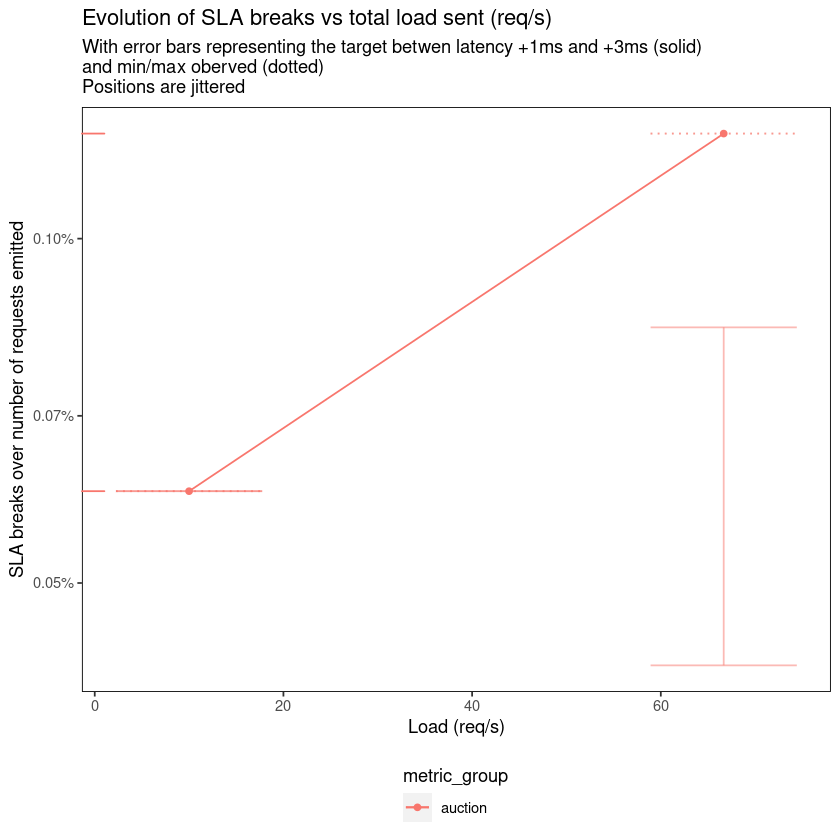

In [71]:
evol_sla_data <- sla_stats %>%
    group_by(load, folder, target_offset, metric_group) %>%
    summarize(above = sum(above), respected = sum(value_bucket)) %>%
    mutate(percent = above / (above + respected)) %>%
    {.}

# evol_sla_data

# fails <- errors %>%
#     group_by(folder, metric_group, period) %>%
#     summarise(failed=sum(value))

# fails <- fails %>%
#     mutate(load = 1000 / period) %>%
#     inner_join(evol_sla_data, c("folder", "metric_group", "load")) %>%
#     mutate(dropped = failed / (broken + respected + failed)) %>%
#     group_by(load, metric_group) %>%
#     summarize(min_dropped = min(dropped), avg_dropped = mean(dropped), max_dropped = max(dropped)) %>%
#     {.}

evol_sla_data <- evol_sla_data %>%
    group_by(load, metric_group, target_offset) %>%
    summarize(min_percent = min(percent), avg_percent = mean(percent), max_percent = max(percent)) %>%
    {.}

# fails <- evol_sla_data %>%
#     group_by(load, metric_group) %>%
#     select(metric_group, load) %>%
#     left_join(fails, by = c("metric_group", "load")) %>%
#     {.}

# fails$avg_dropped <- coalesce(fails$avg_dropped, 0)
# fails$min_dropped <- coalesce(fails$min_dropped, fails$avg_dropped)
# fails$max_dropped <- coalesce(fails$max_dropped, fails$avg_dropped)


# fails


evol_sla <- evol_sla_data %>%
filter(target_offset==0)%>%
ggplot(
  aes(
    x = load,
    y = avg_percent,
    color = metric_group,
  )
) +
geom_rug(sides="l") +
geom_line(position=position_dodge(width=15)) +
geom_errorbar(
    aes(ymin=(evol_sla_data%>%filter(target_offset==0.001))$avg_percent, ymax=(evol_sla_data%>%filter(target_offset==0.003))$avg_percent), 
    width=15.5,
    alpha=0.5,
    linetype = "solid",    
    position=position_dodge(width=15)) +
# geom_errorbar(
#     aes(ymin=(evol_sla_data%>%filter(target_offset==-0.001))$avg_percent, ymax=(evol_sla_data%>%filter(target_offset==0.001))$avg_percent), 
#     width=15.5,
#     alpha=0.5,
#     position=position_dodge(width=15)) +
geom_errorbar(
    aes(ymin=(evol_sla_data%>%filter(target_offset==-0.000))$min_percent, ymax=(evol_sla_data%>%filter(target_offset==0.000))$max_percent), 
    alpha=0.5,
    width=15.5, 
    linetype = "dotted",
    position=position_dodge(width=15)) +
geom_point(position=position_dodge(width=15)) +
scale_y_continuous(label=scales::percent, trans="log10")+
labs(
  x = "Load (req/s)",
  y = "SLA breaks over number of requests emitted",
  title = "Evolution of SLA breaks vs total load sent (req/s)",
  subtitle = "With error bars representing the target betwen latency +1ms and +3ms (solid)\nand min/max oberved (dotted)\nPositions are jittered"
) 
# theme(
#     axis.title.x = element_blank(),
#         legend.position = "none",
#      # axis.text.x = element_text(angle=90)
#      )+
# facet_grid(rows = vars(factor(latency, stringr::str_sort(unique(latency), numeric = TRUE)))) +
# scale_color_viridis(discrete = TRUE, option = "D") +
# scale_fill_viridis(discrete = TRUE)
evol_sla

# fails <- fails %>%
# ggplot(
#   aes(
#     x = load,
#     y = avg_dropped,
#     color = metric_group,
#   )
# ) +
# geom_line() +
# geom_point() +
# geom_errorbar(aes(ymin=min_dropped, ymax=max_dropped)) +
# geom_rug(sides="l") +
# scale_y_reverse(label=scales::percent)+
# scale_x_continuous(position = "top") +
# labs(
#   x = "Load (req/s)",
#   y = "Errors",
#   # title = "Ratio of errors for send window vs load.",
#   color = "Placement model"
# ) +
#  theme(
#         axis.title.x = element_blank(),
#          axis.text.x = element_blank()
#      # axis.text.x = element_text(angle=90)
#  ) + 
# scale_color_viridis(discrete = TRUE, option = "D") +
# scale_fill_viridis(discrete = TRUE)

# cowplot::plot_grid(evol_sla, fails, ncol = 1, rel_heights = c(1, 0.75), align = "H")


In [72]:
# average_with_rmse <- average_sum %>%
#     group_by(folder, load, latency) %>%
#     inner_join(sla_stats) %>%
#     mutate(percent = total / (respected + broken)) %>%
#     {.}

# average_with_rmse %>%
#     ggplot(
#       aes(
#         x = as.numeric(le),
#         y = percent,
#         color = factor(round(load)),
#       )
#     ) +
#     geom_line() +
#     # scale_fill_gradient(trans = 'pseudo_log') +
#     # geom_text(aes(label=round(RMSE)), color = "white", alpha=.7, size = 3) +
#     scale_fill_viridis_c(option="inferno") +
#     # scale_fill_gradient2(low="white",high="red") +
#     scale_y_continuous(label = scales::percent) +
#     facet_grid(rows = vars(folder)) +
#     labs(
#       x = "Load (req/s)",
#       y = "SLA latency targets (ms)",
#       title = "RMSE of latencies",
#       subtitle = "Perceived by the node",
#       fill = "RMSE (s)"
#     )


In [73]:
deployment_times_raw <-
  load_csv("market_function_deployment_time.csv") %>%
  prepare()

`summarise()` has grouped output by 'function_name', 'metric_group'. You can override using the `.groups` argument.


function_name,metric_group,latency_type,min_time,avg_time,max_time
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
echo-001-70-500-100-high-high,auction,high,0.269,0.269,0.269
echo-003-46-500-100-high-high,auction,high,0.398,0.398,0.398
echo-008-69-500-100-high-low,auction,high,0.270,0.270,0.270
echo-013-54-500-100-high-low,auction,high,0.518,0.518,0.518
echo-016-56-500-100-high-high,auction,high,0.368,0.368,0.368
echo-032-56-500-100-high-high,auction,high,0.409,0.409,0.409


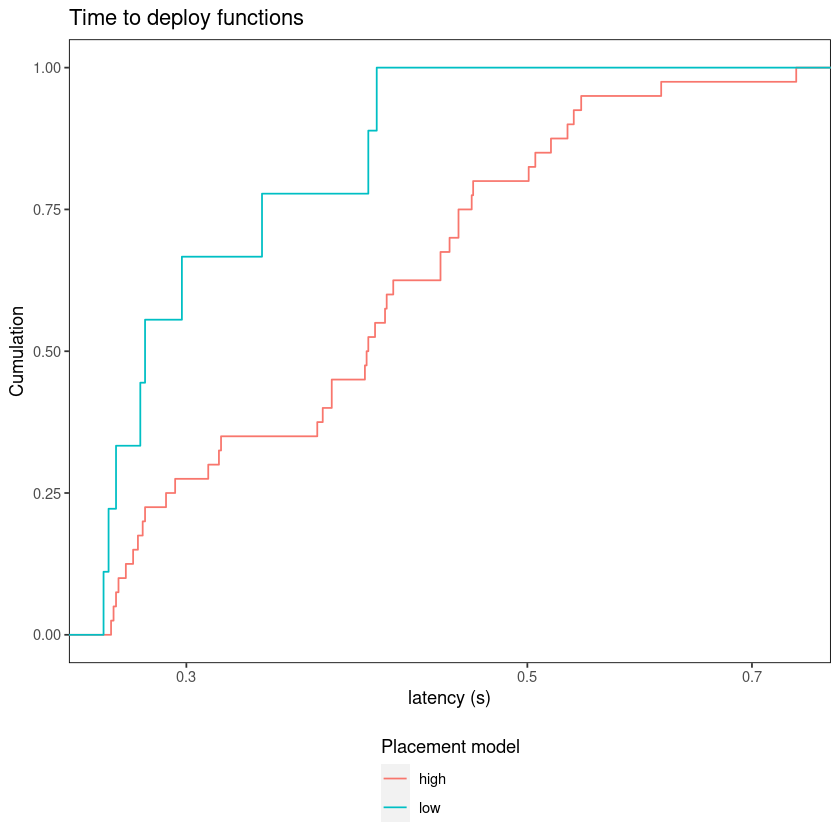

In [74]:
deployment_times <- deployment_times_raw %>%
  select(function_name, folder, metric_group, value) %>%
  distinct() %>%
  drop_na() %>%
  extract_function_name_info() %>%
  group_by(function_name, metric_group, latency_type) %>%
  summarize(min_time = min(value), avg_time = mean(value), max_time = max(value)) %>%
  {.}

head(deployment_times)

deployment_times %>%
ggplot(
  aes(
    x = avg_time,
    # y = value,
    color = latency_type,
  )
) +
stat_ecdf() +
scale_x_continuous(trans = "log10") +
# facet_grid(rows = latency_type) +
# facet_grid(rows = vars(factor(latency_type, stringr::str_sort(unique(latency_type), numeric = FALSE)))) +
labs(
  x = "latency (s)",
  y = "Cumulation",
  title = "Time to deploy functions",
  color = "Placement model")
# scale_color_viridis(discrete = TRUE, option = "D") +
# scale_fill_viridis(discrete = TRUE)